In [7]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from multiprocessing import Pool
import time
from tqdm.notebook import tqdm
import missingno as msno
import plotly.express as px
from utils import get_idle_proportion, get_data_node_sinfo



In [8]:
"""" 
We continue analysing the dataset
Furthermore, we enrich the dataset.
"""

'" \nWe continue analysing the dataset\nFurthermore, we enrich the dataset.\n'

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.precision = 4 # show 4 digits precision
folder_path_slurm_data = Path('./system_analytics_2024/slurm_data')
folder_path_prom_data = Path('./system_analytics_2024/prom_data')
folder_path_saving_results = Path('./results')

prom_file_paths = list(folder_path_prom_data.glob("*.gzip"))
# for getting the up-to-date data run the clenaing_sinfo file
# with the latest data from the system.
df = pd.read_parquet(folder_path_slurm_data / 'sinfo_EDA_cleaned.parquet.gzip')
df.sample(n=5)

,node,time,state,node_type,time_30min_interval,time_1hour_interval,time_2hour_interval,time_3hour_interval,time_6hour_interval,time_12hour_interval,time_day_interval
174,tcn244,2024-11-06 05:15:20,allocated,tcn,2024-11-06 05:00:00,2024-11-06 05:00:00,2024-11-06 04:00:00,2024-11-06 03:00:00,2024-11-06 00:00:00,2024-11-06 00:00:00,2024-11-06
296,tcn337,2024-11-10 11:21:59,allocated,tcn,2024-11-10 11:00:00,2024-11-10 11:00:00,2024-11-10 10:00:00,2024-11-10 09:00:00,2024-11-10 06:00:00,2024-11-10 00:00:00,2024-11-10
16,tcn614,2024-11-13 19:30:58,mixed,tcn,2024-11-13 19:30:00,2024-11-13 19:00:00,2024-11-13 18:00:00,2024-11-13 18:00:00,2024-11-13 18:00:00,2024-11-13 12:00:00,2024-11-13
111,tcn682,2024-11-11 21:30:38,allocated,tcn,2024-11-11 21:30:00,2024-11-11 21:00:00,2024-11-11 20:00:00,2024-11-11 21:00:00,2024-11-11 18:00:00,2024-11-11 12:00:00,2024-11-11
85,tcn401,2024-11-16 15:37:07,mixed,tcn,2024-11-16 15:30:00,2024-11-16 15:00:00,2024-11-16 14:00:00,2024-11-16 15:00:00,2024-11-16 12:00:00,2024-11-16 12:00:00,2024-11-16


In [10]:
""" 
TEMPORRAY: At the end of the EDA notebook or notebooks save a data frame for ML.
"""
# the time interval that we put all the states in it.
map_time_col = {'time_1hour_interval':pd.Timedelta('1h'),
                'time_30min_interval':pd.Timedelta('30min'),
                'time_2hour_interval':pd.Timedelta('2h'),
                'time_3hour_interval':pd.Timedelta('3h'),
                'time_6hour_interval':pd.Timedelta('6h'),
                'time_12hour_interval':pd.Timedelta('12h'),
                }
""
# pick a time col: 
# WHICH TIME INTEVAL MAKES SENSE FOR ML?
time_col = 'time_1hour_interval'
df_stat, df_idle, df_total = get_idle_proportion(df, time_col)
# show a smaple
df_stat.sample(n=5)



,node,time_1hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion
211698,tcn194,2024-11-10 02:00:00,0 days 00:00:00,0 days 00:59:39,0.0000
470130,tcn908,2024-11-14 08:00:00,0 days 00:58:06,0 days 00:58:06,1.0000
423335,tcn78,2024-11-12 22:00:00,0 days 00:00:00,0 days 00:59:48,0.0000
101313,tcn1026,2024-11-15 23:00:00,0 days 00:59:06,0 days 00:59:06,1.0000
232650,tcn252,2024-11-11 02:00:00,0 days 00:01:30,0 days 00:59:38,0.0252


In [11]:
""" 
ENRICHING THE DATA SET:

Get the last state of the node in the interval.
I think it helps the ML algorithm to know not only
the proportion of the time that idle happened but also the actual state of the node.

# Leaking should not happen here. We should not use the state in the future interval

"""

# note the trick here! this happens again in the future for Promethues data
df_last = df.groupby(['node', time_col], as_index=False)[['node', time_col, 'state', 'time']].tail(1).copy()
# merge it with the main
df_stat = pd.merge(df_stat, df_last[['node', time_col, 'state', 'time']],
                   how='left', on=['node', time_col]).copy()
# rename it
df_stat.rename(columns={'time':'time_for_last_state', 'state': 'last_state'}, inplace=True)
# show a sample
df_stat.sample(n=10)


,node,time_1hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion,last_state,time_for_last_state
285266,tcn399,2024-11-09 19:00:00,0 days 00:00:00,0 days 00:59:37,0.0,allocated,2024-11-09 19:59:39
378962,tcn657,2024-11-17 01:00:00,0 days 00:58:05,0 days 00:58:05,1.0,idle,2024-11-17 01:58:07
162756,tcn1196,2024-11-14 14:00:00,0 days 00:59:07,0 days 00:59:07,1.0,idle,2024-11-14 14:59:35
371580,tcn637,2024-11-09 05:00:00,0 days 00:00:00,0 days 00:59:14,0.0,allocated,2024-11-09 05:59:36
429512,tcn797,2024-11-11 10:00:00,0 days 00:00:00,0 days 00:56:19,0.0,allocated,2024-11-11 10:56:30
179545,tcn1242,2024-11-05 15:00:00,0 days 00:59:48,0 days 00:59:48,1.0,idle,2024-11-05 15:59:52
303629,tcn449,2024-11-11 22:00:00,0 days 00:00:00,0 days 00:59:04,0.0,allocated,2024-11-11 22:59:45
133068,tcn1113,2024-11-17 11:00:00,0 days 00:58:05,0 days 00:58:05,1.0,idle,2024-11-17 11:59:06
46671,gcn12,2024-11-14 14:00:00,0 days 00:00:00,0 days 00:59:07,0.0,mixed,2024-11-14 14:59:35
181649,tcn1248,2024-11-11 13:00:00,0 days 00:21:01,0 days 00:21:01,1.0,idle,2024-11-11 13:59:59


In [12]:
"""  
Here we give an example that how the last state can actually be a usefull signal.
The state for this node changes at the very last moment and remains idle for half an hour.
"""

mask = (df['node']=='tcn261') & ((df['time_1hour_interval']==pd.Timestamp('2024-11-13 08:00:00')) 
                                 | (df['time_1hour_interval']==pd.Timestamp('2024-11-13 09:00:00')))
# display(df[mask])

In [13]:
""" 
ENRICHING THE DATA SET:

Bring Promethues data set and get the last step or steps of the mesurements ==> 
WE MUST BRING NEWER DATA AS WELL. 
"""
# read a dataframe
df = pd.read_parquet(folder_path_prom_data / 'metrics_stats_5.parquet.gzip')
# sort based on node and timestemp
df.sort_values(['node', 'timestamp'], inplace=True)
# drop duplicates
df.drop_duplicates(['node', 'timestamp'], inplace=True)
df.head(n=5)

# how to check this df is soreted and does not include duplicates?

: 

: 

: 

In [9]:

# turn the time to pandas time
df['time'] = pd.to_datetime(df['timestamp'], unit='s')
# add the interval tag
df[time_col] = ((df['time'] )).dt.floor(freq=map_time_col[time_col])
# show  a sample
df.head(n=5)

,node,rack,timestamp,node_arp_entries_min,node_arp_entries_max,node_arp_entries_mean,node_arp_entries_median,node_boot_time_seconds_min,node_boot_time_seconds_max,node_boot_time_seconds_mean,node_boot_time_seconds_median,node_context_switches_total_min,node_context_switches_total_max,node_context_switches_total_mean,node_context_switches_total_median,node_cooling_device_cur_state_min,node_cooling_device_cur_state_max,node_cooling_device_cur_state_mean,node_cooling_device_cur_state_median,node_cooling_device_max_state_min,node_cooling_device_max_state_max,node_cooling_device_max_state_mean,node_cooling_device_max_state_median,node_cpu_core_throttles_total_min,node_cpu_core_throttles_total_max,node_cpu_core_throttles_total_mean,node_cpu_core_throttles_total_median,node_cpu_frequency_hertz_min,node_cpu_frequency_hertz_max,node_cpu_frequency_hertz_mean,node_cpu_frequency_hertz_median,node_cpu_frequency_max_hertz_min,node_cpu_frequency_max_hertz_max,node_cpu_frequency_max_hertz_mean,node_cpu_frequency_max_hertz_median,node_cpu_frequency_min_hertz_min,node_cpu_frequency_min_hertz_max,node_cpu_frequency_min_hertz_mean,node_cpu_frequency_min_hertz_median,node_cpu_package_throttles_total_min,node_cpu_package_throttles_total_max,node_cpu_package_throttles_total_mean,node_cpu_package_throttles_total_median,node_disk_io_now_min,node_disk_io_now_max,node_disk_io_now_mean,node_disk_io_now_median,node_disk_read_bytes_total_min,node_disk_read_bytes_total_max,node_disk_read_bytes_total_mean,node_disk_read_bytes_total_median,node_disk_writes_completed_total_min,node_disk_writes_completed_total_max,node_disk_writes_completed_total_mean,node_disk_writes_completed_total_median,node_disk_written_bytes_total_min,node_disk_written_bytes_total_max,node_disk_written_bytes_total_mean,node_disk_written_bytes_total_median,node_filesystem_avail_bytes_min,node_filesystem_avail_bytes_max,node_filesystem_avail_bytes_mean,node_filesystem_avail_bytes_median,node_filesystem_device_error_min,node_filesystem_device_error_max,node_filesystem_device_error_mean,node_filesystem_device_error_median,node_filesystem_files_min,node_filesystem_files_max,node_filesystem_files_mean,node_filesystem_files_median,node_filesystem_files_free_min,node_filesystem_files_free_max,node_filesystem_files_free_mean,node_filesystem_files_free_median,node_filesystem_free_bytes_min,node_filesystem_free_bytes_max,node_filesystem_free_bytes_mean,node_filesystem_free_bytes_median,node_filesystem_size_bytes_min,node_filesystem_size_bytes_max,node_filesystem_size_bytes_mean,node_filesystem_size_bytes_median,node_forks_total_min,node_forks_total_max,node_forks_total_mean,node_forks_total_median,node_hwmon_power_average_interval_max_seconds_min,node_hwmon_power_average_interval_max_seconds_max,node_hwmon_power_average_interval_max_seconds_mean,node_hwmon_power_average_interval_max_seconds_median,node_hwmon_power_average_interval_min_seconds_min,node_hwmon_power_average_interval_min_seconds_max,node_hwmon_power_average_interval_min_seconds_mean,node_hwmon_power_average_interval_min_seconds_median,node_hwmon_power_average_interval_seconds_min,node_hwmon_power_average_interval_seconds_max,node_hwmon_power_average_interval_seconds_mean,node_hwmon_power_average_interval_seconds_median,node_hwmon_power_average_watt_min,node_hwmon_power_average_watt_max,node_hwmon_power_average_watt_mean,node_hwmon_power_average_watt_median,node_hwmon_power_is_battery_watt_min,node_hwmon_power_is_battery_watt_max,node_hwmon_power_is_battery_watt_mean,node_hwmon_power_is_battery_watt_median,node_hwmon_temp_celsius_min,node_hwmon_temp_celsius_max,node_hwmon_temp_celsius_mean,node_hwmon_temp_celsius_median,node_intr_total_min,node_intr_total_max,node_intr_total_mean,node_intr_total_median,node_load1_min,node_load1_max,node_load1_mean,node_load1_median,node_load15_min,node_load15_max,node_load15_mean,node_load15_median,node_load5_min,node_load5_max,node_load5_mean,node_load5_median,node_memory_Active_bytes_min,node_memory_Ac

In [10]:
""" get the last time from promethues data base: 
what was the last measurements from Promethues for this node? """

# note the trick here!
df_prom_last = df.groupby(['node', time_col], as_index=False).tail(1).copy()
df_prom_last.head()


,node,rack,timestamp,node_arp_entries_min,node_arp_entries_max,node_arp_entries_mean,node_arp_entries_median,node_boot_time_seconds_min,node_boot_time_seconds_max,node_boot_time_seconds_mean,node_boot_time_seconds_median,node_context_switches_total_min,node_context_switches_total_max,node_context_switches_total_mean,node_context_switches_total_median,node_cooling_device_cur_state_min,node_cooling_device_cur_state_max,node_cooling_device_cur_state_mean,node_cooling_device_cur_state_median,node_cooling_device_max_state_min,node_cooling_device_max_state_max,node_cooling_device_max_state_mean,node_cooling_device_max_state_median,node_cpu_core_throttles_total_min,node_cpu_core_throttles_total_max,node_cpu_core_throttles_total_mean,node_cpu_core_throttles_total_median,node_cpu_frequency_hertz_min,node_cpu_frequency_hertz_max,node_cpu_frequency_hertz_mean,node_cpu_frequency_hertz_median,node_cpu_frequency_max_hertz_min,node_cpu_frequency_max_hertz_max,node_cpu_frequency_max_hertz_mean,node_cpu_frequency_max_hertz_median,node_cpu_frequency_min_hertz_min,node_cpu_frequency_min_hertz_max,node_cpu_frequency_min_hertz_mean,node_cpu_frequency_min_hertz_median,node_cpu_package_throttles_total_min,node_cpu_package_throttles_total_max,node_cpu_package_throttles_total_mean,node_cpu_package_throttles_total_median,node_disk_io_now_min,node_disk_io_now_max,node_disk_io_now_mean,node_disk_io_now_median,node_disk_read_bytes_total_min,node_disk_read_bytes_total_max,node_disk_read_bytes_total_mean,node_disk_read_bytes_total_median,node_disk_writes_completed_total_min,node_disk_writes_completed_total_max,node_disk_writes_completed_total_mean,node_disk_writes_completed_total_median,node_disk_written_bytes_total_min,node_disk_written_bytes_total_max,node_disk_written_bytes_total_mean,node_disk_written_bytes_total_median,node_filesystem_avail_bytes_min,node_filesystem_avail_bytes_max,node_filesystem_avail_bytes_mean,node_filesystem_avail_bytes_median,node_filesystem_device_error_min,node_filesystem_device_error_max,node_filesystem_device_error_mean,node_filesystem_device_error_median,node_filesystem_files_min,node_filesystem_files_max,node_filesystem_files_mean,node_filesystem_files_median,node_filesystem_files_free_min,node_filesystem_files_free_max,node_filesystem_files_free_mean,node_filesystem_files_free_median,node_filesystem_free_bytes_min,node_filesystem_free_bytes_max,node_filesystem_free_bytes_mean,node_filesystem_free_bytes_median,node_filesystem_size_bytes_min,node_filesystem_size_bytes_max,node_filesystem_size_bytes_mean,node_filesystem_size_bytes_median,node_forks_total_min,node_forks_total_max,node_forks_total_mean,node_forks_total_median,node_hwmon_power_average_interval_max_seconds_min,node_hwmon_power_average_interval_max_seconds_max,node_hwmon_power_average_interval_max_seconds_mean,node_hwmon_power_average_interval_max_seconds_median,node_hwmon_power_average_interval_min_seconds_min,node_hwmon_power_average_interval_min_seconds_max,node_hwmon_power_average_interval_min_seconds_mean,node_hwmon_power_average_interval_min_seconds_median,node_hwmon_power_average_interval_seconds_min,node_hwmon_power_average_interval_seconds_max,node_hwmon_power_average_interval_seconds_mean,node_hwmon_power_average_interval_seconds_median,node_hwmon_power_average_watt_min,node_hwmon_power_average_watt_max,node_hwmon_power_average_watt_mean,node_hwmon_power_average_watt_median,node_hwmon_power_is_battery_watt_min,node_hwmon_power_is_battery_watt_max,node_hwmon_power_is_battery_watt_mean,node_hwmon_power_is_battery_watt_median,node_hwmon_temp_celsius_min,node_hwmon_temp_celsius_max,node_hwmon_temp_celsius_mean,node_hwmon_temp_celsius_median,node_intr_total_min,node_intr_total_max,node_intr_total_mean,node_intr_total_median,node_load1_min,node_load1_max,node_load1_mean,node_load1_median,node_load15_min,node_load15_max,node_load15_mean,node_load15_median,node_load5_min,node_load5_max,node_load5_mean,node_load5_median,node_memory_Active_bytes_min,node_memory_Ac

In [ ]:
# same function as above, it gives us the prom data
# df_prom_last = get_data_node_sinfo(prom_file_paths, map_time_col[time_col], time_col)

# # drop the duplicated columns
# df_prom_last = df_prom_last.T.drop_duplicates().T.copy()




In [12]:
"""  
As we can see many of the rows are NAN, this means that for that specifc node there was no data in Prom.
We have to load other stored data and do the same thing. 
"""
# merge the data with the df_stat
df_stat = pd.merge(df_stat, df_prom_last,
                   how='left', on=['node', time_col]).copy()
df_stat.rename(columns={'time':'time_for_last_prom_measurement'}, inplace=True)
df_stat.sample(n=5)






,node,time_1hour_interval,idle_duration,all_state_durations_in_interval,idle_proportion,last_state,time_for_last_state,rack,timestamp,node_arp_entries_min,node_arp_entries_max,node_arp_entries_mean,node_arp_entries_median,node_boot_time_seconds_min,node_boot_time_seconds_max,node_boot_time_seconds_mean,node_boot_time_seconds_median,node_context_switches_total_min,node_context_switches_total_max,node_context_switches_total_mean,node_context_switches_total_median,node_cooling_device_cur_state_min,node_cooling_device_cur_state_max,node_cooling_device_cur_state_mean,node_cooling_device_cur_state_median,node_cooling_device_max_state_min,node_cooling_device_max_state_max,node_cooling_device_max_state_mean,node_cooling_device_max_state_median,node_cpu_core_throttles_total_min,node_cpu_core_throttles_total_max,node_cpu_core_throttles_total_mean,node_cpu_core_throttles_total_median,node_cpu_frequency_hertz_min,node_cpu_frequency_hertz_max,node_cpu_frequency_hertz_mean,node_cpu_frequency_hertz_median,node_cpu_frequency_max_hertz_min,node_cpu_frequency_max_hertz_max,node_cpu_frequency_max_hertz_mean,node_cpu_frequency_max_hertz_median,node_cpu_frequency_min_hertz_min,node_cpu_frequency_min_hertz_max,node_cpu_frequency_min_hertz_mean,node_cpu_frequency_min_hertz_median,node_cpu_package_throttles_total_min,node_cpu_package_throttles_total_max,node_cpu_package_throttles_total_mean,node_cpu_package_throttles_total_median,node_disk_io_now_min,node_disk_io_now_max,node_disk_io_now_mean,node_disk_io_now_median,node_disk_read_bytes_total_min,node_disk_read_bytes_total_max,node_disk_read_bytes_total_mean,node_disk_read_bytes_total_median,node_disk_writes_completed_total_min,node_disk_writes_completed_total_max,node_disk_writes_completed_total_mean,node_disk_writes_completed_total_median,node_disk_written_bytes_total_min,node_disk_written_bytes_total_max,node_disk_written_bytes_total_mean,node_disk_written_bytes_total_median,node_filesystem_avail_bytes_min,node_filesystem_avail_bytes_max,node_filesystem_avail_bytes_mean,node_filesystem_avail_bytes_median,node_filesystem_device_error_min,node_filesystem_device_error_max,node_filesystem_device_error_mean,node_filesystem_device_error_median,node_filesystem_files_min,node_filesystem_files_max,node_filesystem_files_mean,node_filesystem_files_median,node_filesystem_files_free_min,node_filesystem_files_free_max,node_filesystem_files_free_mean,node_filesystem_files_free_median,node_filesystem_free_bytes_min,node_filesystem_free_bytes_max,node_filesystem_free_bytes_mean,node_filesystem_free_bytes_median,node_filesystem_size_bytes_min,node_filesystem_size_bytes_max,node_filesystem_size_bytes_mean,node_filesystem_size_bytes_median,node_forks_total_min,node_forks_total_max,node_forks_total_mean,node_forks_total_median,node_hwmon_power_average_interval_max_seconds_min,node_hwmon_power_average_interval_max_seconds_max,node_hwmon_power_average_interval_max_seconds_mean,node_hwmon_power_average_interval_max_seconds_median,node_hwmon_power_average_interval_min_seconds_min,node_hwmon_power_average_interval_min_seconds_max,node_hwmon_power_average_interval_min_seconds_mean,node_hwmon_power_average_interval_min_seconds_median,node_hwmon_power_average_interval_seconds_min,node_hwmon_power_average_interval_seconds_max,node_hwmon_power_average_interval_seconds_mean,node_hwmon_power_average_interval_seconds_median,node_hwmon_power_average_watt_min,node_hwmon_power_average_watt_max,node_hwmon_power_average_watt_mean,node_hwmon_power_average_watt_median,node_hwmon_power_is_battery_watt_min,node_hwmon_power_is_battery_watt_max,node_hwmon_power_is_battery_watt_mean,node_hwmon_power_is_battery_watt_median,node_hwmon_temp_celsius_min,node_hwmon_temp_celsius_max,node_hwmon_temp_celsius_mean,node_hwmon_temp_celsius_median,node_intr_total_min,node_intr_total_max,node_intr_total_mean,node_intr_total_median,node_load1_min,node_load1_max,node_load1_mean,node_load1_median,node_load15_min,node_load15_max,node_load15_mean,node_load15_m

<Axes: xlabel='time_1hour_interval'>

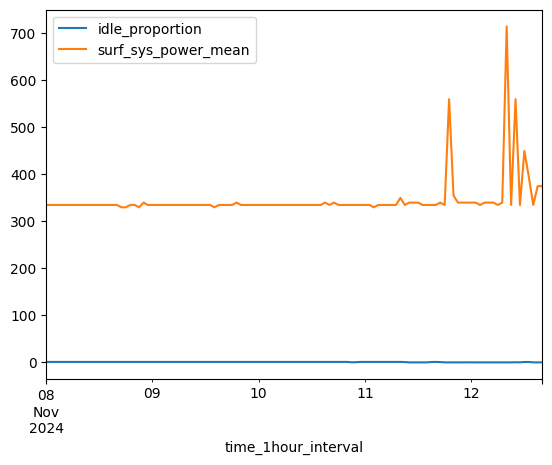

In [ ]:
"""  
Without filtering for the states we would like to plot the idle proportion and power
in the last state

make this figure better, use plotly to have better time series 
"""
import plotly.express as px
# get data for a node and when we have data for it
mask = (df_stat['node']=='fcn14') & (~(df_stat['up_min'].isna()))
df_temp = df_stat[mask].copy()
df_temp.tail()

df_temp.plot(kind='line', x='time_1hour_interval', y=['idle_proportion', 'surf_sys_power_mean'])


In [14]:

""" 
ENRICHING THE DATA SET:
To be done
"""
# get the data from EAR for node waiting time; this enrich the data set


' \nENRICHING THE DATA SET:\nTo be done\n'

In [15]:

""""  
It makes much more sense to save the data here and actually create a note book for machine learning,
since getting all these data from different sources is time consuming.
"""

'"  \nIt makes much more sense to save the data here and actually create a note book for machine learning,\nsince getting all these data from different sources is time consuming.\n'